# [ VAE ] OOD Detection using FSS

In [1]:
%load_ext autoreload
%autoreload 2
import os
import sys
sys.path.append(os.getcwd() + '/core')
sys.path.append(os.getcwd() + '/core/train_GLOW') 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

import core.config as config
from core.model_loader import load_pretrained_VAE
from core.data_loader import TRAIN_loader, TEST_loader
from core.custom_loss import KL_div, VAE_loss_pixel
from core.fisher_utils_VAE import Calculate_fisher_VAE, Calculate_score_VAE, AUTO_VAE
from core.visualize import plot_hist, AUROC, plot_scores_all_layers

# Define Global Variables & Initialize

In [2]:
# FISHER_invs : Fisher inverse matrices from calculating Fisher score (w.r.t. train-dist)
FISHERs = {'cifar10': {}, 'fmnist': {}}
         
# NORMalize_FACtors : Normalizing Factor (w.r.t. train-dist)
NORM_FACs = {'cifar10': {}, 'fmnist': {}}
             
# SCOREs : (Scalars) Scores from calculating Fisher score (w.r.t. target-dist)
SCOREs = {'cifar10': {}, 'fmnist': {}}


# VAE-CIFAR10

In [3]:
opt = config.VAE_cifar10
netE, netG = load_pretrained_VAE(option=opt.train_dist, ngf=64, nz=200, beta=1, augment='hflip', epoch=100)
netE.eval()
netG.eval()

params = {
    #'Emain0_w': netE.main[0].weight,
    #'Emain1_w': netE.main[1].weight,
    #'Emain1_b': netE.main[1].bias,
    #'Emain3_w': netE.main[3].weight,
    #'Emain4_w': netE.main[4].weight,
    #'Emain4_b': netE.main[4].bias,
    #'Emain6_w': netE.main[6].weight,
    #'Emain7_w': netE.main[7].weight,
    #'Emain7_b': netE.main[7].bias,
    'Econv1_w': netE.conv1.weight,
    #'Econv1_b': netE.conv1.bias,
    #'Econv2_w': netE.conv2.weight,
    #'Econv2_b': netE.conv2.bias,
    #'Gmain0_w': netG.main[0].weight,
    #'Gmain1_w': netG.main[1].weight,
    #'Gmain1_b': netG.main[1].bias,
    #'Gmain3_w': netG.main[3].weight,
    #'Gmain4_w': netG.main[4].weight,
    #'Gmain4_b': netG.main[4].bias,
    #'Gmain6_w': netG.main[6].weight,
    #'Gmain7_w': netG.main[7].weight,
    #'Gmain7_b': netG.main[7].bias,
    #'Gmain9_w': netG.main[9].weight,
}


# 추가훈련

In [4]:
for param in netE.parameters():
    param.requires_grad_(False)
for param in netG.parameters():
    param.requires_grad_(False)
for param in netE.conv1.parameters():
    param.requires_grad_(True)
#for param in netE.conv2.parameters():
#    param.requires_grad_(True)

import torch.optim as optim
from torch.autograd import Variable
from datetime import datetime
from tqdm import tqdm

device = 'cuda:0'
optimizer = optim.Adam(netE.conv1.parameters(), lr=5e-5, weight_decay=0)
loss_fn = nn.CrossEntropyLoss(reduction='none')
rec_l, kl = [], []
loader = TRAIN_loader('cifar10', augment=True, batch_size=64)
start = datetime.now()

for epoch in range(10):
    mean_loss = 0.
    for i, (x, _) in enumerate(tqdm(loader)):
        x = x.to(device)
        b = x.size(0)
        target = Variable(x.data.view(-1) * 255).long()
        [z, mu, logvar] = netE(x)
        recon = netG(z)
        recon = recon.contiguous()
        recon = recon.view(-1, 256)
        recl = loss_fn(recon, target)
        recl = torch.sum(recl) / b
        kld = KL_div(mu, logvar)
        loss = recl + 1 * kld.mean()
        
        optimizer.zero_grad()
        total_loss = loss
        loss.backward(retain_graph=True)
        optimizer.step()
        rec_l.append(recl.detach().item())
        kl.append(kld.mean().detach().item())
        mean_loss = (mean_loss * i + loss.detach().item()) / (i + 1)
        
    now = datetime.now()
    print(f'Epoch {epoch+1:02d} recon {np.mean(rec_l):.2f} kl {np.mean(kl):.2f} Elapsed time {now - start}')
    
    

Files already downloaded and verified


  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Epoch 01 recon 11375.67 kl 430.14 Elapsed time 0:00:16.005411


  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Epoch 02 recon 11371.84 kl 430.75 Elapsed time 0:00:31.971946


  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Epoch 03 recon 11369.52 kl 431.22 Elapsed time 0:00:46.685615


  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Epoch 04 recon 11367.82 kl 431.60 Elapsed time 0:01:01.419246


  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Epoch 05 recon 11366.53 kl 431.91 Elapsed time 0:01:16.184542


  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Epoch 06 recon 11365.53 kl 432.18 Elapsed time 0:01:30.965257


  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Epoch 07 recon 11364.68 kl 432.41 Elapsed time 0:01:45.793521


  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Epoch 08 recon 11363.96 kl 432.61 Elapsed time 0:02:00.617246


  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Epoch 09 recon 11363.32 kl 432.80 Elapsed time 0:02:15.429313


100%|████████████████████████████████████████████████████████████████████████████████| 782/782 [00:14<00:00, 52.68it/s]

Epoch 10 recon 11362.75 kl 432.96 Elapsed time 0:02:30.273580


In [10]:
a, b, _scores = AUTO_VAE(opt, netE, netG, params, max_iter=[1000, 1000], loss_type='ELBO_pixel', method='Vanilla')

Files already downloaded and verified


Calculate Fisher VAE:   2%|█                                                     | 999/50000 [00:10<08:21, 97.78step/s]


Files already downloaded and verified


Calculate Score VAE:  10%|█████▍                                                | 999/10000 [00:09<01:28, 102.23step/s]


Using downloaded and verified file: ../data\test_32x32.mat


Calculate Score VAE:  10%|█████▍                                                | 999/10000 [00:09<01:29, 101.03step/s]


Files already downloaded and verified


Calculate Score VAE:  10%|█████▍                                                | 999/10000 [00:09<01:21, 110.24step/s]


Files already downloaded and verified


Calculate Score VAE:  10%|█████▍                                                | 999/10000 [00:07<01:11, 125.84step/s]


In [11]:
for pname in params.keys():
    FISHERs[opt.train_dist][pname] = a[pname] 
    NORM_FACs[opt.train_dist][pname] = b[pname]
    pass
for ood in opt.ood_list:
    SCOREs[opt.train_dist][ood] = _scores[ood]

In [12]:
# AUROC curve
auroc = {}
for pname in params.keys():
    _auroc = {}
    for ood in opt.ood_list:
        args = [
            SCOREs[opt.train_dist][opt.train_dist][pname],
            SCOREs[opt.train_dist][ood][pname],
        ]
        labels = [opt.train_dist, ood]
        _auroc[ood] = AUROC(*args, labels=labels, verbose=False)
    auroc[pname] = _auroc
    
auroc

{'Econv1_w': {'cifar10': 0.49999999999999994,
  'svhn': 0.9032479999999999,
  'celeba': 0.718142,
  'lsun': 0.49095799999999995,
  'cifar100': 0.541376,
  'mnist': 0.997136,
  'fmnist': 0.980405,
  'kmnist': 0.9949110000000001,
  'omniglot': 0.9697380000000001,
  'notmnist': 0.987737,
  'trafficsign': 0.7392920000000001,
  'noise': 0.170525,
  'constant': 0.980683}}

In [6]:
# Just show scores
# plot_scores_all_layers(train_dist, params, SCOREs, opt, save=True)


Files already downloaded and verified


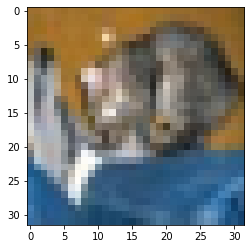

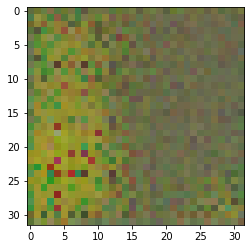

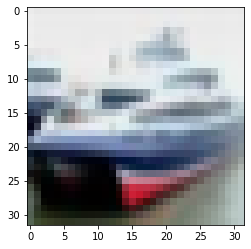

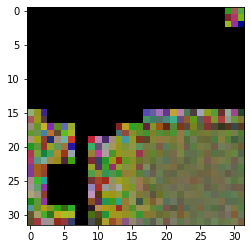

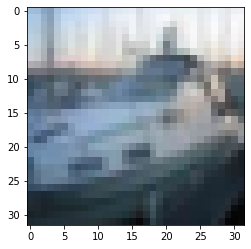

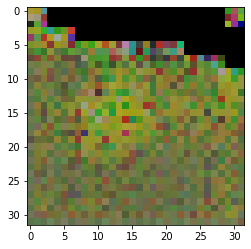

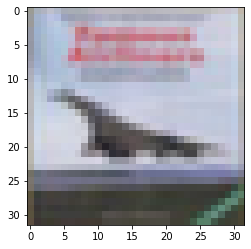

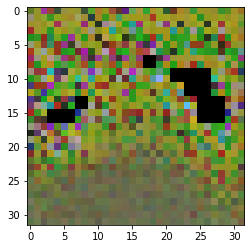

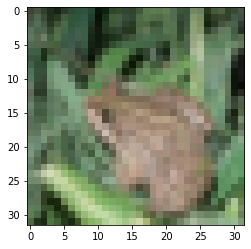

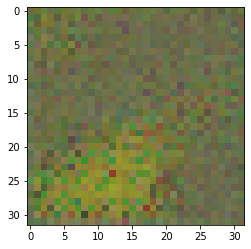

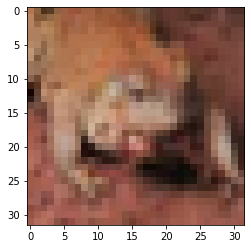

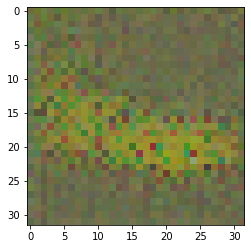

In [8]:
loader = TEST_loader('cifar10', 'cifar10')
for i,(x,_) in enumerate(loader):
    z, mu, logvar = netE(x.cuda())
    y = netG(z)
    plt.figure()
    plt.imshow(x[0].permute(1,2,0).detach().cpu())
    plt.show()
    plt.figure()
    plt.imshow(torch.argmax(y,4)[0].permute(1,2,0).detach().cpu())
    plt.show()
    if i==5:
        break

# VAE-FMNIST

In [14]:
opt = config.VAE_fmnist
netE, netG = load_pretrained_VAE(option=opt.train_dist, ngf=32, nz=100, beta=1, augment='hflip', epoch=100)
netE.eval()
netG.eval()

params = {
    #'Emain0_w': netE.main[0].weight,
    #'Emain1_w': netE.main[1].weight,
    #'Emain1_b': netE.main[1].bias,
    #'Emain3_w': netE.main[3].weight,
    #'Emain4_w': netE.main[4].weight,
    #'Emain4_b': netE.main[4].bias,
    #'Emain6_w': netE.main[6].weight,
    #'Emain7_w': netE.main[7].weight,
    #'Emain7_b': netE.main[7].bias,
    'Econv1_w': netE.conv1.weight,
    #'Econv1_b': netE.conv1.bias,
    #'Econv2_w': netE.conv2.weight,
    #'Econv2_b': netE.conv2.bias,
    #'Gmain0_w': netG.main[0].weight,
    #'Gmain1_w': netG.main[1].weight,
    #'Gmain1_b': netG.main[1].bias,
    #'Gmain3_w': netG.main[3].weight,
    #'Gmain4_w': netG.main[4].weight,
    #'Gmain4_b': netG.main[4].bias,
    #'Gmain6_w': netG.main[6].weight,
    #'Gmain7_w': netG.main[7].weight,
    #'Gmain7_b': netG.main[7].bias,
    #'Gmain9_w': netG.main[9].weight,
}

# 추가훈련

In [13]:
for param in netE.parameters():
    param.requires_grad_(False)
for param in netG.parameters():
    param.requires_grad_(False)
for param in netE.conv1.parameters():
    param.requires_grad_(True)
#for param in netE.conv2.parameters():
#    param.requires_grad_(True)

import torch.optim as optim
from torch.autograd import Variable
from datetime import datetime

device = 'cuda:0'
optimizer = optim.Adam(netE.conv1.parameters(), lr=5e-5, weight_decay=0)
loss_fn = nn.CrossEntropyLoss(reduction='none')
rec_l, kl = [], []
loader = TRAIN_loader('fmnist', 'fmnist')
start = datetime.now()

for epoch in range(10):
    mean_loss = 0.
    for i, (x, _) in enumerate(loader):
        x = x.to(device)
        b = x.size(0)
        target = Variable(x.data.view(-1) * 255).long()
        [z, mu, logvar] = netE(x)
        recon = netG(z)
        recon = recon.contiguous()
        recon = recon.view(-1, 256)
        recl = loss_fn(recon, target)
        recl = torch.sum(recl) / b
        kld = KL_div(mu, logvar)
        loss = recl + 1 * kld.mean()
        
        optimizer.zero_grad()
        total_loss = loss
        loss.backward(retain_graph=True)
        optimizer.step()
        rec_l.append(recl.detach().item())
        kl.append(kld.mean().detach().item())
        mean_loss = (mean_loss * i + loss.detach().item()) / (i + 1)
        
    now = datetime.now()
    print(f'Epoch {epoch+1:02d} recon {np.mean(rec_l):.2f} kl {np.mean(kl):.2f} Elapsed time {now - start}')
    
    

KeyboardInterrupt: 

In [15]:
a, b, _scores = AUTO_VAE(opt, netE, netG, params, max_iter=[1000, 500], loss_type='ELBO_pixel', method='Vanilla')

Calculate Score VAE:   5%|██▋                                                   | 499/10000 [00:03<01:00, 158.19step/s]


Using downloaded and verified file: ../data\test_32x32.mat


Calculate Score VAE:   5%|██▋                                                   | 499/10000 [00:03<01:01, 154.96step/s]


Files already downloaded and verified


Calculate Score VAE:   5%|██▋                                                   | 499/10000 [00:04<01:17, 122.17step/s]


Files already downloaded and verified


Calculate Score VAE:   5%|██▋                                                   | 499/10000 [00:03<01:00, 157.05step/s]


Files already downloaded and verified


Calculate Score VAE:   5%|██▋                                                   | 499/10000 [00:02<00:42, 225.44step/s]


In [16]:
for pname in params.keys():
    FISHERs[opt.train_dist][pname] = a[pname] 
    NORM_FACs[opt.train_dist][pname] = b[pname]
for ood in opt.ood_list:
    SCOREs[opt.train_dist][ood] = _scores[ood]

In [17]:
# AUROC curve
auroc = {}
for pname in params.keys():
    _auroc = {}
    for ood in opt.ood_list:
        args = [
            SCOREs[opt.train_dist][opt.train_dist][pname],
            SCOREs[opt.train_dist][ood][pname],
        ]
        labels = [opt.train_dist, ood]
        _auroc[ood] = AUROC(*args, labels=labels, verbose=False)
    auroc[pname] = _auroc
    
auroc

{'Econv1_w': {'fmnist': 0.5,
  'svhn': 0.9986119999999999,
  'celeba': 0.9945280000000001,
  'lsun': 0.997316,
  'cifar10': 0.995068,
  'cifar100': 0.995388,
  'mnist': 0.974432,
  'kmnist': 0.983492,
  'omniglot': 1.0,
  'notmnist': 0.996924,
  'noise': 0.972576,
  'constant': 0.996012}}

In [9]:
# Just show scores
# plot_scores_all_layers(train_dist, params, SCOREs, opt, save=True)